# Lab 4 : Non-negative Matrix Factorization

##### Made by Damien Chambon and João Gabriel Lopes de Oliveira

The goal of this lab session is to code a NMF algorithm and use it in some applications.

You have to send the filled notebook named **"NMF_familyname1_familyname2.ipynb"** (groups of 2) by email to *lucca.guardiola@centralesupelec.fr* by November 12, 2020 and put **"AML-NMF"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

# NMF - Recap

Non-negative Matrix Factorization is a model where a matrix X is factorized into two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to interpret.


Loss (Regularized Froebnius): $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|H\|_{F}^{2}+\lambda\|H\|_{1}+\frac{\nu}{2}\|W\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999] (http://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf)

\begin{array}{c}
W \leftarrow W .* \left(X H^T\right)./W \left(H H^{\top} + {\color{red} \nu I_r}\right) \\
H \leftarrow H .* \left(W^{\top} X - {\color{red} \lambda 1_{r \times n}}\right)./\left((W^{\top} W + {\color{red} \mu I_r})H\right)
\end{array}


.* is the dot product ( in python  : A*B ) 

AB is the matrix product ( in python : A@B )

## Initialization 

The computation time and the convergence of the NMF depends on how you initialize the matrices W and H.
You will implement and compare two types of initialization. 

#### Random initialization : 

$\forall i,j, H^0_{i,j}\sim U_{[0,1]}$ and $ W^0_{i,j}\sim U_{[0,1]} $

Each term of $W^0$ and $H^0$ is sampled with a uniform distribution. Use np.random.random(Matrix_shape)

#### NNDSVD initialization : 

Singular value decomposition (SVD) is a classical method that extends the eigen-decomposition to non-square matrix.

For any $ X \in \mathbb{R}^{N\times M}$, there exists a factorization with the following form:

$$ X = U \Sigma V^T $$

With $ U \in \mathbb{R}^{N\times N} , \Sigma  \in \mathbb{R}^{N\times M} \text{ such as } \Sigma = \begin{pmatrix} 
\Sigma_1 & 0 \\
0 & 0 
\end{pmatrix} , V \in \mathbb{R}^{M\times M} $



$\Sigma_1 = diag(σ1, σ2, ..., σr)$, and the diagonal entries are sorted in descending order, i.e. σ1 ≥ σ2 ≥ ... ≥ σr > 0,
σi, i = 1, 2, ...r being the singular values with r = rank(Z)


After the computation of the SVD of X, the initialization of W and H is made with  

$$ W^0 = |U_{:,:r}|$$
$$ H^0 = | \Sigma_{:r,:}V^T| $$ 
$|.|$ means the absolute value for each term of the matrix, r = number of components of the NMF :

You will need : 
np.linalg.svd 

Watch out np.linalg.svd returns only the diagonal of $\Sigma$. I advise you ton create a empty matrix $\Sigma$ with np.zeros(Shape of the matrix) then fill the diagonal with np.diag(). You can use the exemple in https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html



### Tasks  :  
- Fill the fit transform function. Consider $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}$ (no regularization)
- Implement NNSVD initialization and random initialization. 
- Return W H and the Froebenius norm of the residuals (the loss) when the convergence condition is fulfilled.

(This should take you less than 30 minutes)

In [2]:
# REGULARIZED AND NON-REGULARIZED IMPLEMENTATION COMBINED HERE
class my_NMF():
    
    def __init__(self, n_components, epsilon,init, max_iter = 60):
        '''
        Attributes:
        
        n_components_ : integer
            the unknown dimension of W and H
        max_iter_: integer
            maximum number of iterations
        epsilon_ : float
        init_ :  {"random", "NNDSVD"}
        w_: np.array
            W Matrix factor
        H_: np.array
            H Matrix factor
        '''
        self.n_components = n_components
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.init = init
        self.W = None
        self.H = None
        
        
    def fit_transform(self, X,regularized,l = None,v = None,mu=None):
        """ Find the factor matrices W and H
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        regularized: if True, regularization, otherwise no regularization
        l, v, mu: lambda, v and mu, parameters of the regularization
        
        Returns:
        -----
        W,H,loss
        """        
        
        
        if self.init == 'NNDSVD' : 
            #TODO
            #Initialize W and H with a SVD of X
            u, s, vh = np.linalg.svd(X)
            W=np.abs(u[:,:self.n_components])
            smat = np.zeros((u.shape[0], vh.shape[0]))
            smat[:u.shape[0], :u.shape[0]] = np.diag(s)
            H = smat[:self.n_components,:]@vh
        elif self.init == 'random' :
            #TODO
            #Initialize W and H by generating uniform samples.
            W = np.random.random([X.shape[0],self.n_components])
            H = np.random.random([self.n_components,X.shape[1]])
        
        convergence = False 
        number_iter = 0
        
        while not(convergence) : 
            #The convergence is reached when the number of iteration is equal to self.max_iter or
            #when the loss < self.epsilon
            
            
            #TODO 
            #Update W and H for each iteration
            if regularized:
                # With regularization
                W = (W * (X@H.T)) / (W@(H@H.T + v*np.eye(self.n_components)))
                H = (H * (W.T@X-l*np.ones([self.n_components,X.shape[1]]))) / ((W.T@W + mu*np.eye(self.n_components))@H)
            else:
                # Without regularization
                W = (W * (X@H.T)) / (W@H@H.T)
                H = (H * (W.T@X)) / (W.T@W@H)
            
            number_iter+=1
            
            if regularized:
                #regularized loss function
                # first term of regularized loss function
                loss = (1/2)*np.sqrt(np.sum((X-W@H)**2))
                                     
                # second term of regularized loss function
                loss+= (mu/2)*np.sqrt(np.sum((H)**2))
                
                # third term of regularized loss function
                loss+= l*np.sum(np.abs(H))
                
                # fourth term of regularized loss function
                loss+= (v/2)*np.sqrt(np.sum((W)**2))
            else:
                #unregularized loss function
                loss = np.sqrt(np.sum((X-W@H)**2))                
            
            if (number_iter==self.max_iter) or (loss<self.epsilon):
                #stop the algorithm
                convergence = True
        self.W = W
        self.H = H
                    
        return self.W,self.H,loss


### Bonus : Implement the regularized version

## Applications

### First application - Images

For the first application you are going to analyse the following data to give an interpretation of the factorization:

(400, 4096)

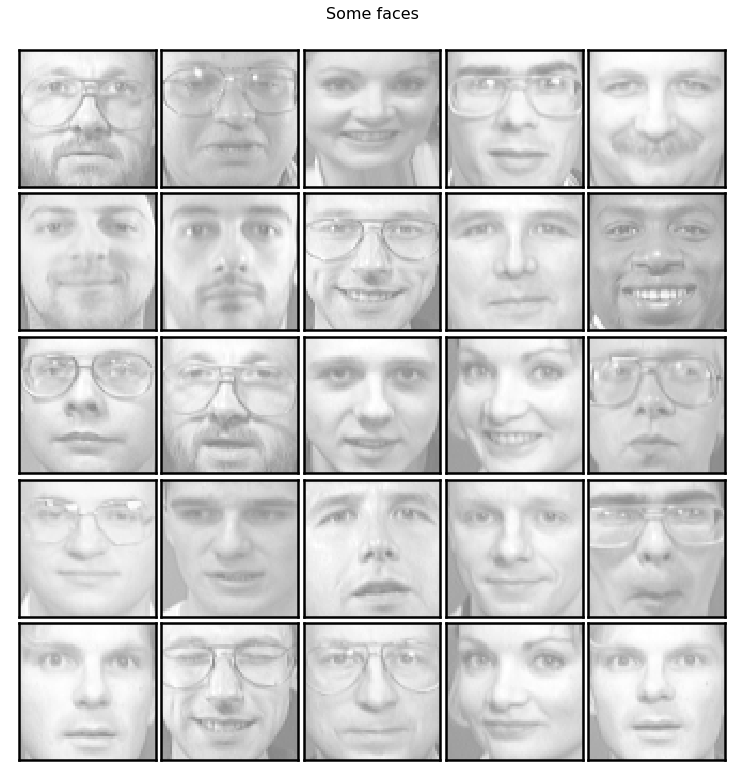

In [3]:
from sklearn.datasets import fetch_olivetti_faces

dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data
image_shape = (64, 64)

n_samples, n_features = faces.shape

def plot_faces(title, images, image_shape, n_col=5, n_row=5, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
plot_faces("Some faces", faces[:25], image_shape)

faces.shape

### Task : apply your NMF algorithm to this dataset and plot the approximated face pictures. Compare the different initializations

78.80321583325589


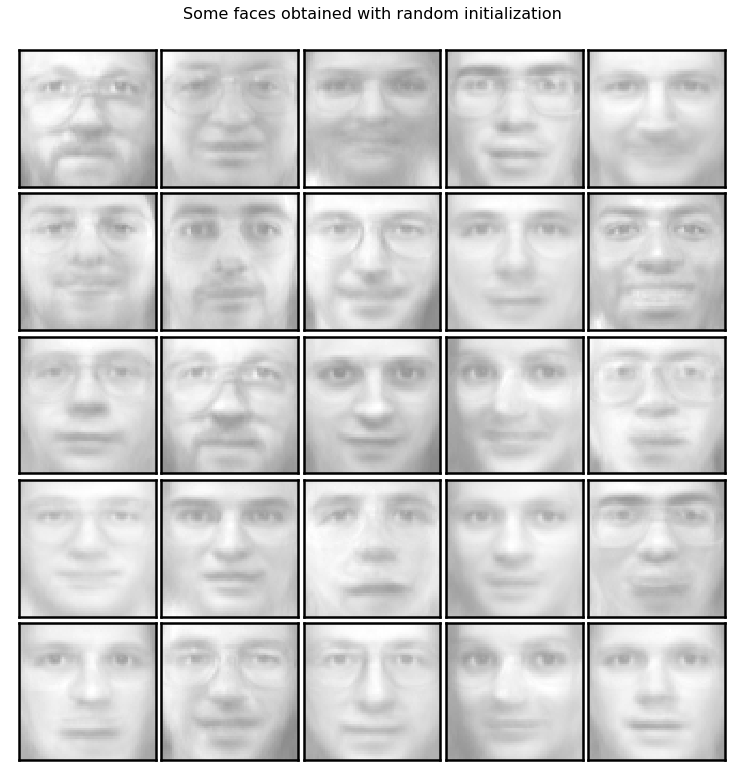

In [4]:
# TODO
NMF1 = my_NMF(36,0.0001,'random',500)
W1,H1,loss1 = NMF1.fit_transform(faces,regularized=False)
#W1,H1,loss1 = NMF1.fit_transform(faces,True,1,2,100)
print(loss1)
approx_faces1 = W1@H1
plot_faces("Some faces obtained with random initialization", approx_faces1[:25], (64,64))

71.53099878724281


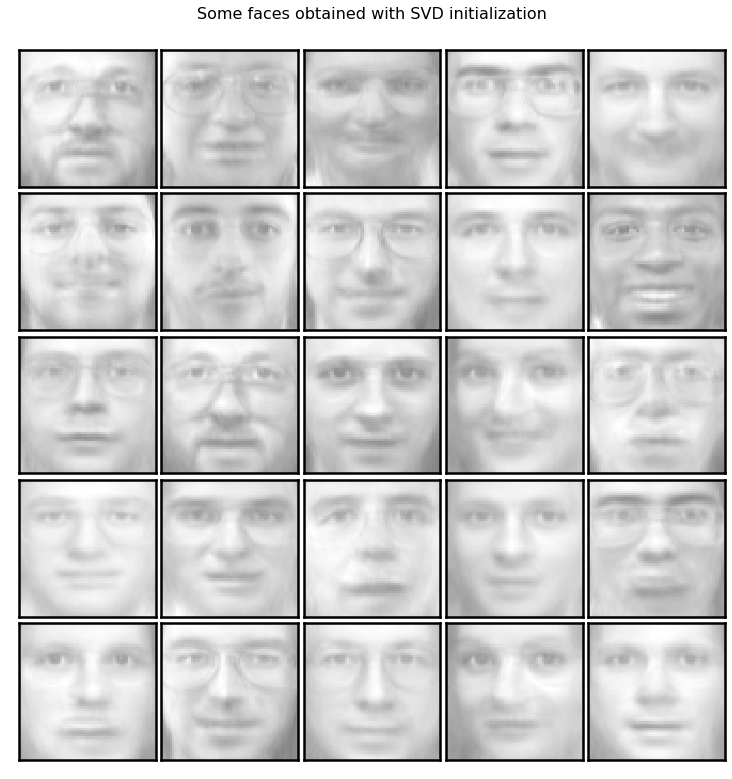

In [5]:
# TODO
NMF2 = my_NMF(36,0.0001,'NNDSVD',500)
W2,H2,loss2 = NMF2.fit_transform(faces,regularized=False)
#W2,H2,loss2 = NMF2.fit_transform(faces,True,1,2,3) #does not work properly: remaining cost function is really high
print(loss2)
approx_faces2 = W2@H2
plot_faces("Some faces obtained with SVD initialization", approx_faces2[:25], (64,64))

**Comparison between random and SVD initialization**: The results are very similar after that many iterations. The loss is a bit lower for the SVD initialization showing that it may converge faster than random initialization.

### Tasks :  
- Apply NMF with the SVD initialisation and with a number of components r such as $\sqrt r$ is an integer (r = 4,16,etc..) 
- Plot the $H$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid ( n_col=n_row=$\sqrt r $)
- Choose one face, plot its corresponding weights (in $W$) in a grid 
- How can we interpret the matrices H and W.

Be careful with the arguments image_shape, n_col n_row in the plot_faces function

92.64771698716969


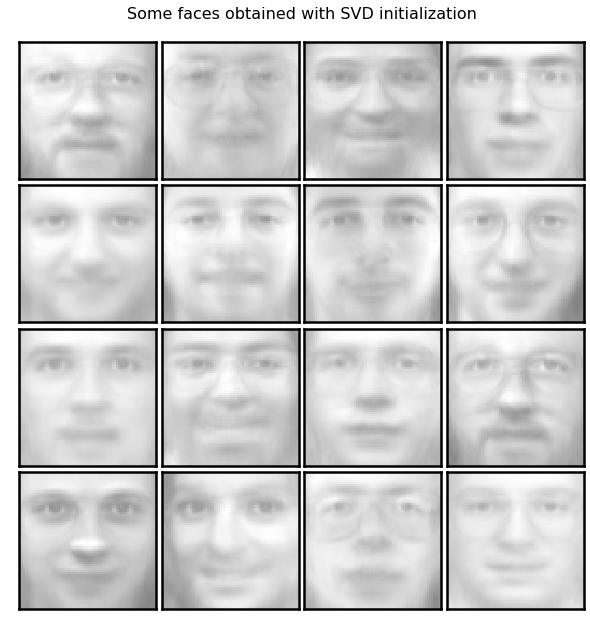

In [6]:
#TODO
#We choose r = 16
theNMF = my_NMF(4*4,0.0001,'NNDSVD',500)
W_final,H_final,loss_final = theNMF.fit_transform(faces,regularized=False)
print(loss_final)
approx_faces_final = W_final@H_final
plot_faces("Some faces obtained with SVD initialization", approx_faces_final[:16], (64,64),4,4)

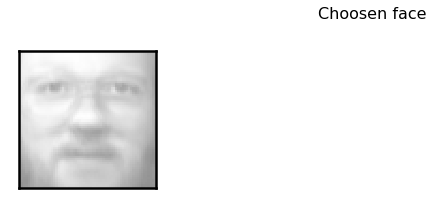

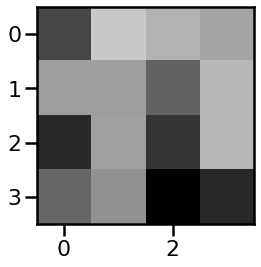

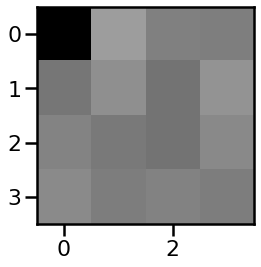

In [7]:
#We choose face 0
plot_faces("Choosen face", approx_faces_final[:1], (64,64))
plt.show()
comp = W_final[0,:]
vmax = max(comp.max(), -comp.min())
plt.imshow(comp.reshape(4,4), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
plt.show()
comp = H_final[:,0]
vmax = max(comp.max(), -comp.min())
plt.imshow(comp.reshape(4,4), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
plt.show()

**Analysis:** We can interpret the coefficients of W as follows. W has as many elements as the number of components. Each component is used to create an approximation of the elements that are present in all the faces. Here, for face 0, we see that the left part and the lower part of his face have a higher coefficient that the rest, meaning that those components are used more heavily to reconstruct the original face. Indeed, that is where the man has his beard, which is distinctive from the others.

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 news documents from 20 different newsgroups (i.e 20 different topics like art news, geopolitical news etc...)

The goal of this exercice is to model the topics present with NMF then print the most common words of each topic.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups

n_samples = 5000
n_features = 2000
n_components = 10
n_top_words = 20

def print_top_words(D, feature_names, n_top_words):
    p, r = D.shape
    for topic_idx in range(r):
        topic = D[:, topic_idx]
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]


print(data_samples[:3]) # A few exemple of news 

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n", "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap 

### Feature extraction/engineering 

Before applying NMF, you have to convert text into numerical values in order to vectorize your documents.

We will be looking at the Count vectorizer method and the TF-IDF vectorizer.

### Count vectorizer. 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

We define a corpus by an ensemble of documents $(D_1,...D_N)$. From this corpus we collect all the different words used in the documents, this collection of words $(w_1,...w_p)$ is called the vocabulary of the corpus.

Using the count vectorizer, the numerical representation of a document $D_i$ will be Count_Vectoriser$(D_i) = \sum_{j=1}^p f_{ij}w_j $ With f_ij, the frequency of appearence of the word $w_j$ in the document $i$.

### TF-IDF

Task : Search for TF-IDF. Explain its principle and its difference with count_vectorizer

Answer : 

TF-IDF is a statistic that defines the importance of a given word to a document in a corpus. Its value increases as a word is more used a single document, much like Count Vectorizer. 

However, the difference is that TF-IDF is reduced by the amount of documents that contain a given word. Therefore, the TF-IDF value is also offset by the number of documents that contain the given word. Therefore, words that are present in multiple documents (and therefore, more frequent in general in the corpus) will have less weight, since they are not discriminative of a given document (and thus, it can be said that they are less important).


### Task : Vectorize your document with Count Vectorizer or TF-IDF. 
#### Put in argument stop_words='english'  and max_features=n_features 
Stop_words is a list of common words that don't bring any information like 'the', 'a' etc... We don't want these words to take up space in our database for computation time reason and because they could harm the numerical representation of the documents. 

You must obtain a $5000\times2000$ shaped matrix 

*Note: We will apply the model on both in order to compare their results.*

In [9]:
# With cv_vec
cv_vec = CountVectorizer(stop_words='english', max_features=n_features)
X_cv = cv_vec.fit_transform(data_samples)
print(X_cv.shape)

(5000, 2000)


In [10]:
# With tfidf_vec
tfidf_vec = TfidfVectorizer(stop_words='english', max_features=n_features)
X_tf = tfidf_vec.fit_transform(data_samples)
print(X_tf[0])

  (0, 1383)	0.11218000243566437
  (0, 825)	0.10265829355629366
  (0, 969)	0.14601530900881304
  (0, 1063)	0.10580464468793686
  (0, 264)	0.12230958633839316
  (0, 1094)	0.12082891012798479
  (0, 828)	0.11509561662466937
  (0, 1484)	0.14151174659450266
  (0, 1683)	0.16875187555730198
  (0, 146)	0.16191692629397014
  (0, 1521)	0.1463658736090887
  (0, 422)	0.1412156749660553
  (0, 1519)	0.14781279830172864
  (0, 1478)	0.11756013128806136
  (0, 1812)	0.08022894132772007
  (0, 557)	0.16875187555730198
  (0, 1854)	0.10792851928151333
  (0, 1030)	0.14933692799042714
  (0, 565)	0.15795027792275235
  (0, 1476)	0.1489482055795135
  (0, 678)	0.16253137269527632
  (0, 1052)	0.15742603098537306
  (0, 859)	0.1142809194896622
  (0, 1972)	0.11175672570914788
  (0, 960)	0.32029821078099957
  (0, 1404)	0.1467207931604388
  (0, 1123)	0.589776558219559
  (0, 1726)	0.13762236100758457
  (0, 592)	0.16315932448868847
  (0, 578)	0.09699453198427518
  (0, 1739)	0.14063258010577329
  (0, 1767)	0.10175598731051


### Task : Apply NMF from sklearn with a choosen initialization. Then print the top words for each topics with print_top_words

Use tfidf_vectorizer.get_feature_names() to recover the words. 

In [11]:
from sklearn.decomposition import NMF

In [12]:
model = NMF(n_components=50, init='random', random_state=123)
W_cv = model.fit_transform(X_cv) 
H_cv = model.components_.T
print_top_words(H_cv, cv_vec.get_feature_names(), 10)

Topic #0: ax max b8f a86 giz 1d9 pl bhj 75u mr
Topic #1: window motif information manager available offers mit xt subject xlib
Topic #2: ax max g9v b8f a86 2di 75u 145 bhj 1d9
Topic #3: file gun congress control firearms mr states united rkba 1991
Topic #4: air bh ah 34 rk 145 mk t5 2d b9r
Topic #5: ax g9v max a86 b8f km 1d9 bj mr gk
Topic #6: cx hz c_ 17 s6 mv m6 lk 24 ck
Topic #7: mr stephanopoulos president know don think said going did groups
Topic #8: ax max b8f bhj 75u a86 2di 0d 1d9 pl
Topic #9: 00 01 000 won lost new chicago york san 10
Topic #10: cx c_ sp ub ck w7 s1 w1 bn sq
Topic #11: 55 66 72 61 48 min 71 44 la 36
Topic #12: 00 appears 40 50 art 10 80 1st 70 25
Topic #13: probe mars lunar surface moon space orbit earth mission missions
Topic #14: police san anti said league francisco information los angeles groups
Topic #15: 145 2di 0d bh bhj 75u ah q5o b8f ao
Topic #16: mv m0 mp mu mt md mw m3 mi mm
Topic #17: ah 34u pl b8 7u b9r ahf 6g air 5u
Topic #18: car oil dot tires 

In [13]:
model = NMF(n_components=50, init='random', random_state=12515)
W_tf = model.fit_transform(X_tf)
H_tf = model.components_.T
print_top_words(H_tf, tfidf_vec.get_feature_names(), 10)

Topic #0: don think mean really little better pretty try wrong want
Topic #1: like sounds looks lot make source look things thing doing
Topic #2: sale shipping offer price condition sell asking excellent best email
Topic #3: problem problems fix fixed memory machine make fine defined server
Topic #4: know don let appreciated anybody help want wanted area happen
Topic #5: key keys bit public keyboard des session escrow shift rsa
Topic #6: did didn fbi forget years sure koresh evidence ago news
Topic #7: thanks advance hi info email tell appreciated anybody wondering appreciate
Topic #8: deleted stuff heard speed guess lots little different day nice
Topic #9: card drivers video driver cards vga vlb bus graphics memory
Topic #10: scsi bus controller ide bit isa data mac pc memory
Topic #11: monitor color screen colors image display apple switch video 16
Topic #12: file files format swap sound directory image win gif copy
Topic #13: good luck bad book pretty want early using thing comments

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


* Both approaches seem to find discrimative words for the topics. However, the simpler approach from Count Vectoizer gives rather noisy results, mixing very discriminative words together with rather mundane/meaningless word-strings in some topics. However, for TF-IDF the results are much clearer. Almost every word is very discriminative and the subjects from each of the topics can even be inferred by the words themselves.*

*From now on, our analysis will be based only in TF-IDF*

The relevance of the topics can be improved with better parameters in the vectorizer, a more advanced cleaning in addition to the stopwords (for instance getting rid of the numbers etc ...) or more advanced vectorizer/encoder like Word2Vec or Doc2Vec which use very simple neural networks. 

### Imagine we would like to gather the news coming from the same newsgroup/news category. How would you do using the NMF and the previous courses ? 

Answer :

Previously, we obtained a NMF model that is able to transform an input string into a vector of weights where the weights get higher when the words associated with their respective topic are found in the text. This means that we have a translation from string to this "topic likelihood" space.

We can then use this new space as parameters for a classification model. In the previous exercise, we had only extracted the text data. Since our original data is shuffled, so we also cannot distinguish the original class of any of the samples, thus making this a clustering problem (which was studied in lab 2).

However, a second approach is also possible using the vector target available from fetch_20newsgroups. With this information, we have a target and we can use classification algorithms (lab 3). 

The supervised approach usually generates a superior classifier, since it has the ground truth established by a human to rely on. However, in the real world this is not always available. Therefore, the following section we will explore both approaches. 

### Implement your solution.

## Unsupervised Approach

We can say that the weights for a topic roughly represents the importance of that topic in our text. Since our texts come from different newsgroups, it is reasonable to assume that different newsgroups will approach topics differently.

Since in an unsupervised context we don't know how many different newsgroups really exist in our dataset, we can apply an inertia analysis on k-means in order to see roughly the amount of clusters necessary in order to separate our data.

In [14]:
from sklearn.cluster import KMeans
def plot_inertia(k_min,k_max,data):
    """ Fit several kmeans models with different K in order to find visually the optimal K with the elbow method 

    Output : 
    plot the inertia as a function of the number of clusters
    """
    inertia = []
    for k in range(k_min,k_max):
        # for each k, we compute the inertia and append it to the list of inertias
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
        
    plt.plot([k for k in range(k_min,k_max)],inertia)


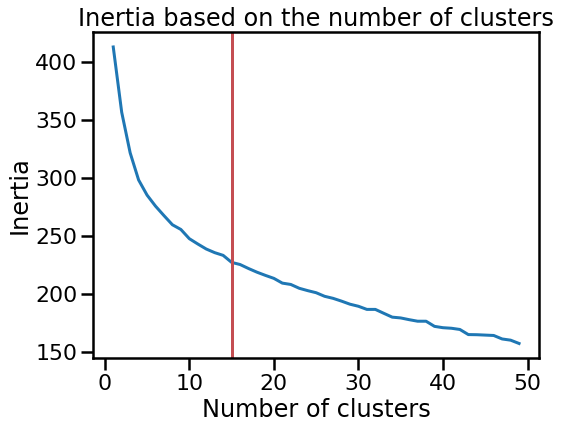

In [15]:
plt.figure(figsize=(8, 6))
plot_inertia(1,50, W_tf)
plt.axvline(x=15,color='r') # adding a red line to show where the elbow is located
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia based on the number of clusters')
plt.show()

We can see that although this plot seems to present an elbow ending roughly at 5-10 clusters, it decreases almost linearly from there. This means that we don't have a clear cut amount of clusters in our data.

This is reasonable given the complexity of natural language data and the level of granularity one desires from a model (should European Politics and Middle East's Politics sections be in the same cluster?).

In order to alleviate this tradeoff, we select a number of clusters to around 15.

In [16]:
kmeans = KMeans(n_clusters=15, random_state=1)
kmeans.fit(W_tf)
import collections
print(collections.Counter(kmeans.labels_))

Counter({12: 2399, 0: 538, 1: 439, 13: 243, 8: 219, 5: 175, 2: 167, 10: 157, 9: 153, 11: 137, 14: 117, 3: 87, 7: 78, 4: 56, 6: 35})


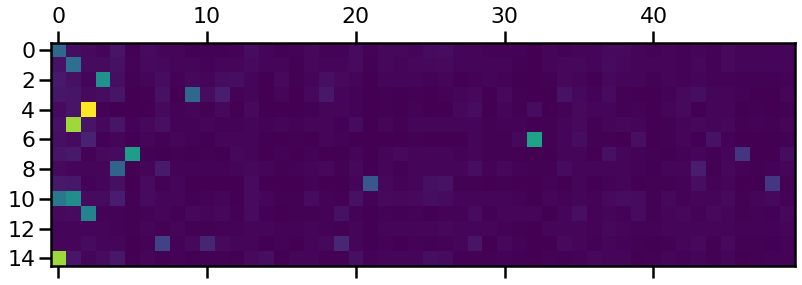

In [17]:
plt.matshow(kmeans.cluster_centers_)

#### Working with new data

We will now create some new dummy data that we can input into this pipeline.

Our data needs then to go past the **same transformation process** that our training pipeline went through in order for the computation to be consistent.

In [18]:
new_string_space = ["Yesterday, Nasa sent a space shuttle from the earth to the moon's orbit"]

new_vec = tfidf_vec.transform(new_string_space)
print(type(new_vec), new_vec.shape)
print(new_vec)

<class 'scipy.sparse.csr.csr_matrix'> (1, 2000)
  (0, 1995)	0.38697490805709095
  (0, 1699)	0.284581053053781
  (0, 1654)	0.3939701520999217
  (0, 1623)	0.32227056911649243
  (0, 1283)	0.38064694009551986
  (0, 1206)	0.3452394348331653
  (0, 1176)	0.37769563594352795
  (0, 634)	0.32164715222416007


In [19]:
W_new = model.transform(new_vec)
print(W_new)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.27692979e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.88200565e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


With our weights for the new string, we can see the closest mean from k-means to assign it to a new newsgroup.

In [20]:
kmeans.predict(W_new)

array([12])

Let's look at some articles from this cluster to see if our results were reasonable!

In [21]:
cluster_indexes = [i for i, x in enumerate(kmeans.labels_) if x==kmeans.predict(W_new)[0]]

for i in range(5):
    print(data_samples[cluster_indexes[i]])

Notwithstanding all the legitimate fuss about this proposal, how much
of a change is it?  ATT's last product in this area (a) was priced over
$1000, as I suspect 'clipper' phones will be; (b) came to the customer 
with the key automatically preregistered with government authorities. Thus,
aside from attempting to further legitimize and solidify the fed's posture,
Clipper seems to be "more of the same", rather than a new direction.
   Yes, technology will eventually drive the cost down and thereby promote
more widespread use- but at present, the man on the street is not going
to purchase a $1000 crypto telephone, especially when the guy on the other
end probably doesn't have one anyway.  Am I missing something?
   The real question is what the gov will do in a year or two when air-
tight voice privacy on a phone line is as close as your nearest pc.  That
has got to a problematic scenario for them, even if the extent of usage
never surpasses the 'underground' stature of PGP.
Archive-name

## Supervised approach

In order to enable this approach, we will extract the target data from our dataset.

In [22]:
y = dataset.target[:n_samples]

# Remember that we will train using the NMF weighs as parameters
X = W_tf 

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

Enabling a train/test split in order to detect overfitting

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

Let's start our approach by looking at a rather direct LogisticRegression approach.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [26]:
# Logistic regression
model1 = LogisticRegression(multi_class="auto", max_iter=5000).fit(X_train, y_train)

In [27]:
y_predict = model1.predict(X_test)
print('Accuracy: ', accuracy_score(y_predict, y_test))

Accuracy:  0.4890909090909091


This approach gives us around 48% classification accuracy.

We can also compare this approach with different classification methods. For instance, SVC with different kernels.

In [28]:
kernels = ["linear", "poly", "rbf", "sigmoid"]

for kernel in kernels:
    
    clf = svm.SVC(kernel=kernel).fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    
    print(kernel)
    print('Accuracy: ', accuracy_score(y_predict, y_test))
    print('----------') 

#AUC is the best with a kernel = rbf. Its performance is better than the improved version of Logistic Regression

linear
Accuracy:  0.46545454545454545
----------
poly
Accuracy:  0.28363636363636363
----------
rbf
Accuracy:  0.4533333333333333
----------
sigmoid
Accuracy:  0.4290909090909091
----------


Only RBF seemed to provide results comparable to the logistic regression, if not slightly lower.

We can finally compare with a LDA model to see if it can break the 45% threshold.

In [29]:
model3 = LDA().fit(X_train, y_train)
y_predict = model3.predict(X_test)

print('Accuracy: ', accuracy_score(y_predict, y_test))

Accuracy:  0.4393939393939394


It seems that all three aproaches hit a ceiling around 45%. Since LogisticRegression presented ever so slightly better results, we can use it as our final model for this problem!

We can apply a final grid_search in order to see if there are improvements available by feature tuning.

In [30]:
from sklearn.model_selection import GridSearchCV

parameters = {'multi_class':('auto', 'ovr', 'multinomial'), 'C': [0.1, 0.3, 1, 10, 30]} 

lr = LogisticRegression(max_iter=3000)
clf=GridSearchCV(lr, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=3000),
             param_grid={'C': [0.1, 0.3, 1, 10, 30],
                         'multi_class': ('auto', 'ovr', 'multinomial')})

In [31]:
clf.best_params_

{'C': 0.3, 'multi_class': 'ovr'}

In [32]:
y_predict = clf.predict(X_test)

print('Accuracy: ', accuracy_score(y_predict, y_test))

Accuracy:  0.47515151515151516


As it can be seen, even with feature engineering the model hits a ceiling around 48% for our 20 class problem. Given the 5% chance of a random model, the lack of semantic information provided to the model and the proximity of the subject from many of the articles (for example: 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware'), we believe that this result was succesful in proving the viability of NMF for newsgroup distiction.

As a final step, we can finally use this model to predict our new input data.

In [33]:
clf.predict(scaler.transform(W_new))

array([14])

In [34]:
dataset.target_names[14]

'sci.space'

Our model assigns the proof-of-concept sentence "Yesterday, Nasa sent a space shuttle from the earth to the moon's orbit" into the space section, which is reasonable. This approach can be extended then to multiple new sentences and articles.